# **Projet Apprentissage Machine:** Analyse de performance académique (Student Performance Dataset – **Kaggle**) 

### **<u>Objectif:</u>**
1. Régression pour prédire les notes finales.
2. Classification (succès vs échec).
3. Clustering des profils d’étudiants. 
4. Ensembles pour combiner les prédictions.

### **Description du jeu de données**:
- Ce jeu de données contient les notes des étudiants au Lycée (États-Unis) pour certaines matières, et l'influence du bagage parentale sur les performances académiques.

  - _gender_           -            (female, male)
  - _race/ethnicity_       -        (group C, group D, group B, group E, group A)
  - _parental level of education_ - (some college, associate's degree, high school, some high school,bachelor's degree)
  - _lunch_           -             (standard, free/reduced)
  - _test preparation course_   -   (none, completed)
  - _math score_         -          (Between 0 and 100) 
  - _reading score_       -         (Between 17 and 100) 
  - _writing score_        -        (Between 10 and 100) 

## **1. Chargement et préparation des données**

### **<u>Tâches à faire</u>**:
1. Nettoyage, encodage des variables catégorielles, normalisation. 
2. Gestion des valeurs manquantes. 
3. Analyse descriptive des données.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

import random
import os

In [2]:
# La reproductibilite
# La graine aleatoire
# au cas ou un utilisateur travail dans systeme different
SEED = 42
random.seed(SEED)
np.random.seed(seed=SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

### (a) Chargement des données

In [3]:
df = pd.read_csv("../data/StudentsPerformance.csv") # Update l'import du dataset
df.head(10)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
5,female,group B,associate's degree,standard,none,71,83,78
6,female,group B,some college,standard,completed,88,95,92
7,male,group B,some college,free/reduced,none,40,43,39
8,male,group D,high school,free/reduced,completed,64,64,67
9,female,group B,high school,free/reduced,none,38,60,50


### (b) Nettoyage des données

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [5]:
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [6]:
# Vérifie les doublons
df.duplicated().sum()

0

In [7]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [8]:
#valeurs uniques
df.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

In [9]:
# sélection des colonnes catégoriel
categoriel_col = df.select_dtypes(exclude=["number"]).columns
categoriel_col

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course'],
      dtype='object')

In [10]:
# sélection des colonnes numerique
numerical_col = df.select_dtypes(exclude=["object"]).columns
numerical_col

Index(['math score', 'reading score', 'writing score'], dtype='object')

### (c) Encodage des colonnes catégorielles

In [11]:
# encodage des colonnes catégorielles
categoriel_df = df[categoriel_col]
print(f"Nombre de colonnes catégorielles à traiter: {len(categoriel_col)}")
categoriel_df.head(10)

Nombre de colonnes catégorielles à traiter: 5


,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,female,group B,bachelor's degree,standard,none
1,female,group C,some college,standard,completed
2,female,group B,master's degree,standard,none
3,male,group A,associate's degree,free/reduced,none
4,male,group C,some college,standard,none
5,female,group B,associate's degree,standard,none
6,female,group B,some college,standard,completed
7,male,group B,some college,free/reduced,none
8,male,group D,high school,free/reduced,completed
9,female,group B,high school,free/reduced,none


### (d) One Hot Encoding (OHE)

In [12]:
# one hot encoding pour la colonne gender et test preparation course

# 1 - OHE des caractéristiques `gender`, `lunch` et `test preparation course`
categoriel_df = pd.get_dummies(categoriel_df, columns=['gender', 'lunch', 'test preparation course'])
categoriel_df.head()

,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,group B,bachelor's degree,True,False,False,True,False,True
1,group C,some college,True,False,False,True,True,False
2,group B,master's degree,True,False,False,True,False,True
3,group A,associate's degree,False,True,True,False,False,True
4,group C,some college,False,True,False,True,False,True


### (e) Ordinal Encoder (OE)

In [13]:
#encodage ordinal

# 2 - OE de la caractéristique `parental level of education`
# L'ordre défini est important
# Conserve l'importance de chaque niveau d'éducation des parents.

encodage = OrdinalEncoder(categories=[["high school", "some high school", "some college", "associate's degree", "bachelor's degree", "master's degree"]])
encodage.fit(categoriel_df[['parental level of education']])
categoriel_df['parental level of education'] = encodage.transform(categoriel_df[['parental level of education']])

categoriel_df

# 0 = high school
# 1 = some high school
# 2 = some college
# 3 = associate's degree
# 4 = bachelor's degree
# 5 = master's degree

,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,group B,4.0,True,False,False,True,False,True
1,group C,2.0,True,False,False,True,True,False
2,group B,5.0,True,False,False,True,False,True
3,group A,3.0,False,True,True,False,False,True
4,group C,2.0,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...
995,group E,5.0,True,False,False,True,True,False
996,group C,0.0,False,True,True,False,False,True
997,group C,0.0,True,False,True,False,True,False
998,group D,2.0,True,False,False,True,True,False


### (f) Encodage de fréquence (FE)

In [14]:
# Encodage de fréquence

# 3 - `FE` de la caractéristique `race/ethnicity`
encodage_freq = categoriel_df['race/ethnicity'].value_counts(normalize=True)
categoriel_df['race/ethnicity'] = categoriel_df['race/ethnicity'].map(encodage_freq)
categoriel_df.head()

,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,0.190,4.0,True,False,False,True,False,True
1,0.319,2.0,True,False,False,True,True,False
2,0.190,5.0,True,False,False,True,False,True
3,0.089,3.0,False,True,True,False,False,True
4,0.319,2.0,False,True,False,True,False,True


### ~~(g) Encodage de cible (TE)~~

In [15]:
# encodage de cible
# aucun besoin d'encoder par cible car il n'existe aucune cible apparente
# avec laquelle associer notre variable à encoder.

# 4 - La caractéristique `lunch` est encodée plus haut, par OHE et non OE car il n'y a pas 
# réellement de relation d'ordre entre les catégories `['standard', 'free/reduced']`

# df_encodage_cible = pd.DataFrame({'lunch': ['standard', 'free/reduced'], 'target': [0,1]})
# mean_cb = df_encodage_cible.groupby('lunch')['target'].mean()
# df['lunch'] = df['lunch'].map(mean_cb)
# df

### (h) Normalisation/Standardisation des données

In [16]:
# L'encodage ordinal a créer des colonnes numériques
# Fusionner les colonnes catégorielles et numériques
numerical_df = df[numerical_col]
clean_df = pd.concat([categoriel_df, numerical_df], axis=1) # Fusionner `categoriel_df` et `numerical_df`
print(f'Taille des données nettoyées: {clean_df.shape}\n')

# Normalisation/Standardisation des données
# Avec `MinMaxScaler`
min_max_scaler = MinMaxScaler()
min_max_scaler.set_output(transform="pandas")
min_max_scaler.fit(clean_df)

donnees_normaliser = min_max_scaler.transform(clean_df)
print(f'Données scalées avec `MinMaxScaler`, aperću: \n{donnees_normaliser.iloc[0:3, 0:4]}')

Taille des données nettoyées: (1000, 11)

Données scalées avec `MinMaxScaler`, aperću: 
   race/ethnicity  parental level of education  gender_female  gender_male
0         0.43913                          0.8            1.0          0.0
1         1.00000                          0.4            1.0          0.0
2         0.43913                          1.0            1.0          0.0


In [17]:
# Fusionner les colonnes catégorielles et numériques
# On évite d'utiliser le `clean_df` déjà fitté sur le `MinMaxScaler`
clean_df = pd.concat([categoriel_df, numerical_df], axis=1) # Fusionner `categoriel_df` et `numerical_df`
print(f'Taille des données nettoyées: {clean_df.shape}\n')

# Avec `StandardScaler`
standard_scaler = StandardScaler()
standard_scaler.set_output(transform="pandas")


donnees_standardisees = standard_scaler.fit_transform(clean_df)
print(f'Données scalées avec `StandardScaler`, aperću: \n\n{donnees_standardisees.iloc[:3, :4]}')

Taille des données nettoyées: (1000, 11)

Données scalées avec `StandardScaler`, aperću: 

   race/ethnicity  parental level of education  gender_female  gender_male
0       -0.569024                     1.310052       0.964625    -0.964625
1        1.098265                    -0.043308       0.964625    -0.964625
2       -0.569024                     1.986732       0.964625    -0.964625


## **2. Analyse exploratoire et visualisation**

### **<u>Tâches à faire</u>**:
1. Visualisations des distributions et corrélations. 
2. Graphiques par classes, regroupements, ou tendances temporelles (si 
applicable).

### Effectuons l'analyse exploratoire sur les données prétraitées (`clean_df`).
Le prétraitement ne modifie en rien la pertinence des données. Elle les mets sous une forme plus pratique pour les modèles.

In [18]:
# Aperću de `clean_df`
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   race/ethnicity                     1000 non-null   float64
 1   parental level of education        1000 non-null   float64
 2   gender_female                      1000 non-null   bool   
 3   gender_male                        1000 non-null   bool   
 4   lunch_free/reduced                 1000 non-null   bool   
 5   lunch_standard                     1000 non-null   bool   
 6   test preparation course_completed  1000 non-null   bool   
 7   test preparation course_none       1000 non-null   bool   
 8   math score                         1000 non-null   int64  
 9   reading score                      1000 non-null   int64  
 10  writing score                      1000 non-null   int64  
dtypes: bool(6), float64(2), int64(3)
memory usage: 45.1 KB


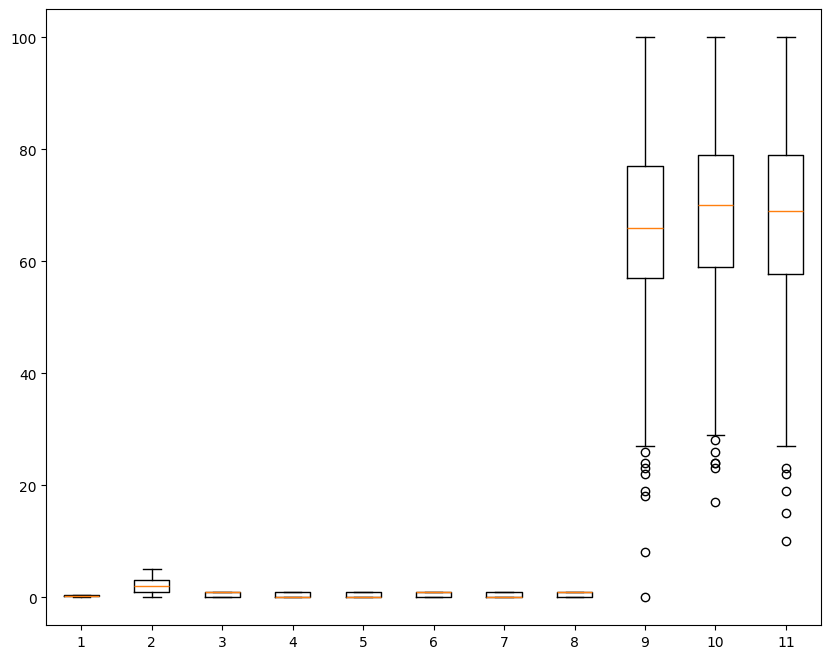

In [19]:
# colonnes_a_tracer = ['math score', 'reading score', 'writing score']
# plt.boxplot(clean_df[colonnes_a_tracer])
### Il y a dans chacun à peu près le même nombre de valeurs abérantes

plt.figure(figsize=(10, 8))
plt.boxplot(clean_df)
plt.show()

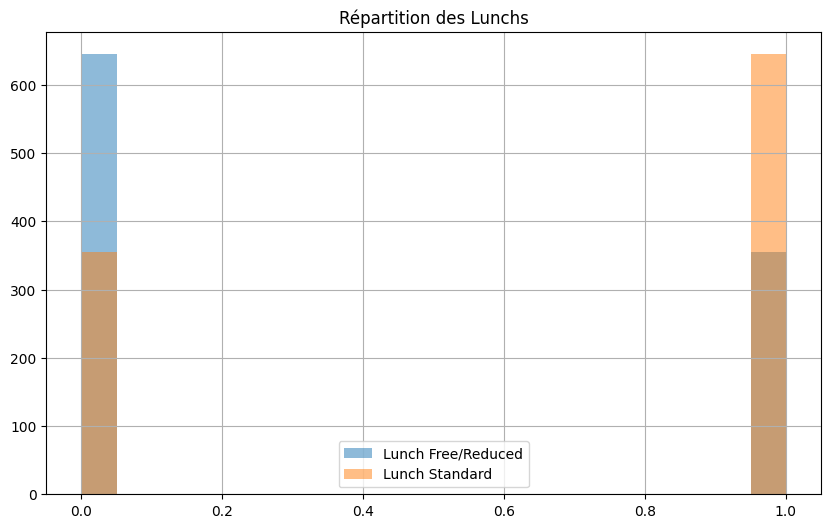

In [20]:
#histogramme pour représenter la répartion de chaque type de lunch
plt.figure(figsize=(10, 6))
plt.hist(clean_df['lunch_free/reduced'].astype(int), bins=20, alpha=0.5, label='Lunch Free/Reduced')
plt.hist(clean_df['lunch_standard'].astype(int), bins=20, alpha=0.5, label='Lunch Standard')

plt.title('Répartition des Lunchs')

plt.legend()
plt.grid()
plt.show()

### Corrélations

<Axes: >

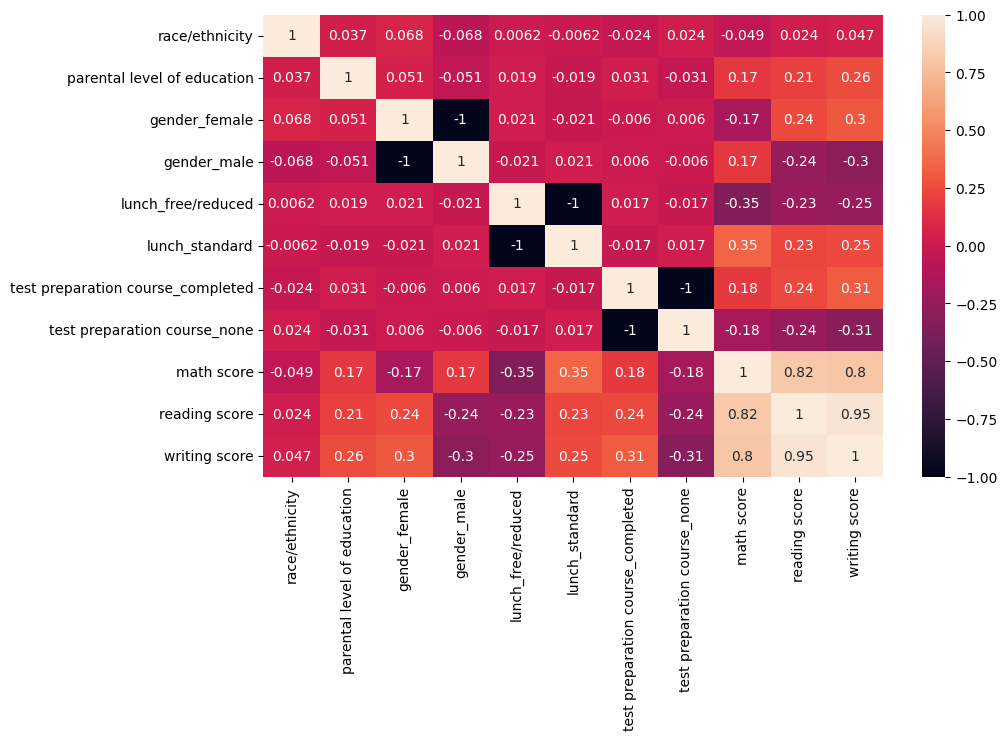

In [21]:
#matrice de corrélation de spearman
corr_matrix_pearson = clean_df.corr()
plt.figure(figsize=(10,6))

sns.heatmap(corr_matrix_pearson, annot=True)

In [22]:
clean_df['test preparation course_completed'].value_counts()

test preparation course_completed
False    642
True     358
Name: count, dtype: int64

In [23]:
clean_df['race/ethnicity'].value_counts()

race/ethnicity
0.319    319
0.262    262
0.190    190
0.140    140
0.089     89
Name: count, dtype: int64

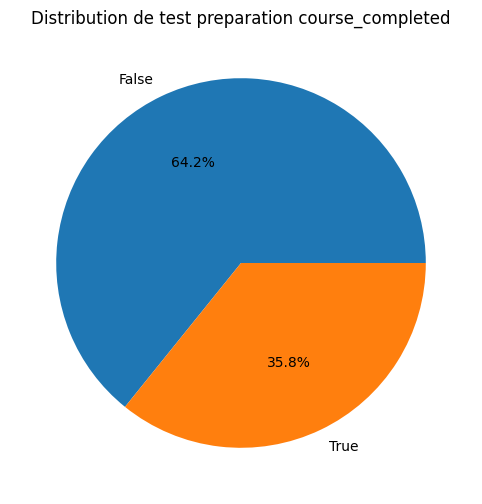

In [24]:
# diagramme circulaire de la colonne test preparation course completed

compte1 = clean_df['test preparation course_completed'].value_counts()

plt.figure(figsize=(8,6))
plt.pie(compte1.values, labels=compte1.index, autopct='%1.1f%%')
plt.title('Distribution de test preparation course_completed')

plt.show()

In [25]:
# Le nombre d'étudiant est plus large dans le groupe '0.319'
df_mode_race_eth = clean_df['race/ethnicity'].mode()

df_mode_race_eth

0    0.319
Name: race/ethnicity, dtype: float64

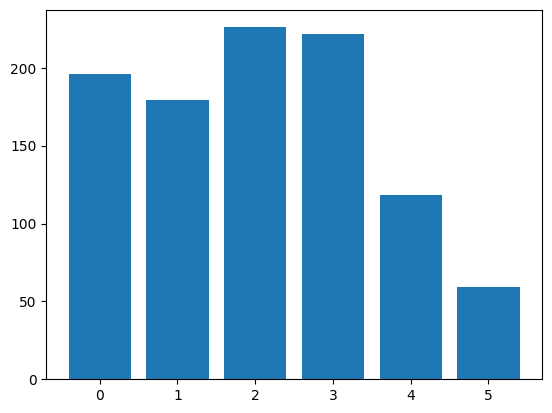

In [26]:
#histogramme pour la colonne 'parental level of education'
compte = clean_df['parental level of education'].value_counts()
plt.bar(compte.index, compte.values)
plt.show()

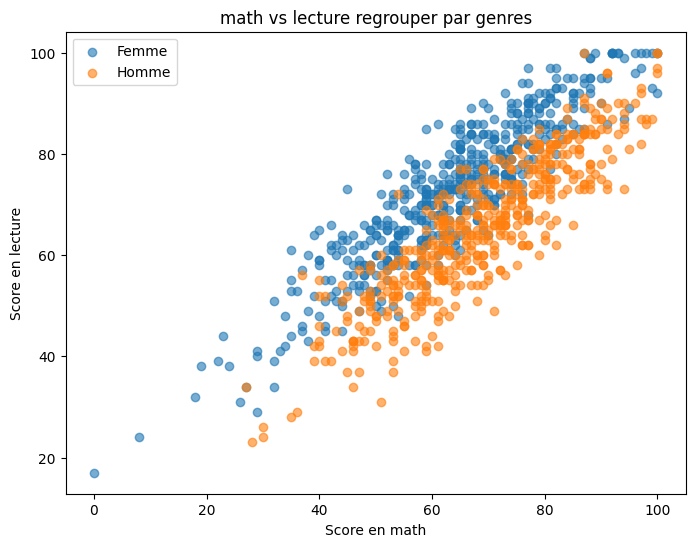

In [27]:
#Nuage de points : coloré par genre
plt.figure(figsize=(8,6))
plt.scatter(clean_df[clean_df['gender_female'] == 1]['math score'], clean_df[clean_df['gender_female'] == 1]['reading score'], label='Femme', alpha=0.6)
plt.scatter(clean_df[clean_df['gender_male'] == 1]['math score'], clean_df[clean_df['gender_male'] == 1]['reading score'], label='Homme', alpha=0.6)
plt.title("math vs lecture regrouper par genres")
plt.xlabel("Score en math")
plt.ylabel("Score en lecture")
plt.legend()
plt.show()

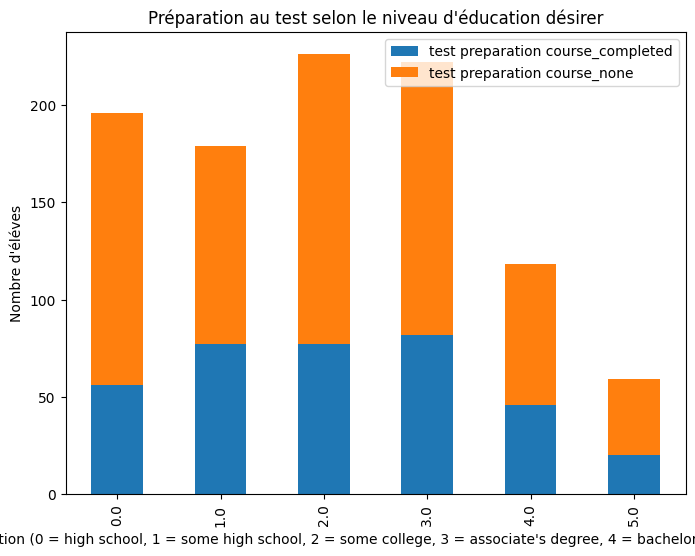

In [28]:
# Diagramme à bande
#Création d'un tableau croisé
prep_level_education = clean_df.groupby('parental level of education')[['test preparation course_completed', 'test preparation course_none']].sum()


prep_level_education.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title("Préparation au test selon le niveau d'éducation désirer")
plt.xlabel("Type de niveau d'éducation (0 = high school, 1 = some high school, 2 = some college, 3 = associate's degree, 4 = bachelor's degree, 5 = master's degree)")
plt.ylabel("Nombre d'éléves")
plt.show()

# Il y a plus d'étudiant qui ne se sont pas préparé à leur test.

In [29]:
# Séparation des données
y = df["test preparation course"].map({'none': 0, 'completed': 1}) # cible
X = df.drop(columns="test preparation course") # caracteristiques

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED, stratify=y) # Pour utilisation directe
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.25, random_state=SEED, stratify=y) # Pour utilisation dans pipeline


Définition de la pipeline de reproduction

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

one_hot_columns = ['gender', 'lunch', 'race/ethnicity'] # ajout de la colonne 'race/ethnicity'
ordinal_encoder_categories = ["high school", "some high school", "some college", "associate's degree", "bachelor's degree", "master's degree"]
ordinal_encoder_columns = ['parental level of education']
numerical_col = ['math score', 'reading score', 'writing score']

#label_encoding_columns = ['race/ethnicity']


# preprocesseur categoriel
preprocessor_categoriel = ColumnTransformer(transformers=[
    ("one_hot", OneHotEncoder(sparse_output=False), one_hot_columns),
    ("ordinal", OrdinalEncoder(categories=[ordinal_encoder_categories]), ordinal_encoder_columns),
    ("scaler", StandardScaler(), numerical_col)
    #("label", LabelEncoder(), label_encoding_columns)
], remainder='passthrough')

# pipeline standardiser
pipeline_scaler = Pipeline(steps=[
    ("preprocessing", preprocessor_categoriel),
    ("scaler", StandardScaler())
])

#pipelines complet avec PCA standardisation et normalisation
pipeline_pca_scaler = Pipeline(steps=[
    ("preprocessing", preprocessor_categoriel),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2))
])

pipeline_pca_minmax = Pipeline(steps=[
    ("preprocessing", preprocessor_categoriel),
    ("min_max", MinMaxScaler()),
    ("pca", PCA(n_components=2))
])

In [31]:
# Apercu du df
X_train.head()

,gender,race/ethnicity,parental level of education,lunch,math score,reading score,writing score
239,male,group C,associate's degree,standard,84,80,80
735,male,group C,master's degree,standard,67,57,59
259,female,group C,master's degree,free/reduced,65,81,81
516,female,group D,some college,standard,74,89,84
594,female,group C,bachelor's degree,standard,92,100,99


In [32]:
# Pretraitement direct/manuel
X_train = preprocessor_categoriel.fit_transform(X_train)
X_test = preprocessor_categoriel.transform(X_test)  # avec transform on évite la fuite de données

### **3. Modélisation supervisée**

### **<u>Tâches à faire</u>**:
1. Entraîner au moins deux modèles différents (ex. : régression 
linéaire/logistique, SVM, arbres de décision). 
2. Comparer les performances avec validation croisée et métriques adaptées 
(précision, rappel, RMSE, etc.).

In [33]:
#Entrainement de deux modèles (SVM, Arbre) 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

modelSVM = SVC(kernel='linear', probability=True, random_state=SEED)
ModelArbre = DecisionTreeClassifier(random_state=SEED)

modelSVM.fit(X_train, y_train)
ModelArbre.fit(X_train, y_train)

pred_SVM = modelSVM.predict(X_test)
pred_Arbre = ModelArbre.predict(X_test)

print("Score (SVM): ", accuracy_score(y_test, pred_SVM))
print("Score (Arbre): ", accuracy_score(y_test, pred_Arbre))
print("Score de précision (SVM): ", precision_score(y_test, pred_SVM))
print("Score de précision (Arbre): ", precision_score(y_test, pred_Arbre))
print("rappel (SVM): ", recall_score(y_test, pred_SVM))
print("rappel (Arbre): ", recall_score(y_test, pred_Arbre))

Score (SVM):  0.78
Score (Arbre):  0.62
Score de précision (SVM):  0.75
Score de précision (Arbre):  0.4727272727272727
rappel (SVM):  0.5730337078651685
rappel (Arbre):  0.5842696629213483


In [34]:
# Entrainement avec pipeline
#pipeline normaliser pour decision Tree
pipeline_min_max_tree = Pipeline(steps=[
    ("preprocessing", preprocessor_categoriel),
    ("min_max", MinMaxScaler()),
    ("tree", DecisionTreeClassifier(random_state=SEED))
])
#Entraînement de la pipeline
pipeline_min_max_tree.fit(X_train_p, y_train_p)
# score
print("Score pipelin arbre:", pipeline_min_max_tree.score(X_test_p, y_test_p))

#prédictions
pred_Arbre_pipeline = pipeline_min_max_tree.predict(X_test_p)

print("Score de précision (Arbre): ", precision_score(y_test_p, pred_Arbre_pipeline))
print("rappel (Arbre): ", recall_score(y_test_p, pred_Arbre_pipeline))

Score pipelin arbre: 0.612
Score de précision (Arbre):  0.4642857142857143
rappel (Arbre):  0.5842696629213483


In [35]:
#pipeline standardiser pour SVM
pipeline_scaler_svm= Pipeline(steps=[
    ("preprocessing", preprocessor_categoriel),
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel='rbf', probability=True, random_state=SEED))
])
#Entrainements
pipeline_scaler_svm.fit(X_train_p, y_train_p)
print("Score pipelin svm:", pipeline_scaler_svm.score(X_test_p, y_test_p))

#prédictions
pred_svm_pipeline = pipeline_scaler_svm.predict(X_test_p)

print("Score de précision (SVM): ", precision_score(y_test_p, pred_svm_pipeline))
print("rappel (SVM): ", recall_score(y_test_p, pred_svm_pipeline))

Score pipelin svm: 0.688
Score de précision (SVM):  0.6410256410256411
rappel (SVM):  0.2808988764044944


In [36]:
# Validaiton croisée
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

scores_SVM = cross_val_score(pipeline_scaler_svm, X_train_p, y_train_p, cv=kf, scoring='accuracy')
scores_Arbre = cross_val_score(pipeline_min_max_tree, X_train_p, y_train_p, cv=kf, scoring='accuracy')

print("validaiton croisé (SVM) moyenne: ", f'{scores_SVM.mean():.2f} +/- {scores_SVM.std():.2f}')
print("validaiton croisé (Arbre) moyenne: ", f'{scores_Arbre.mean():.2f} +/- {scores_Arbre.std():.2f}')

validaiton croisé (SVM) moyenne:  0.65 +/- 0.03
validaiton croisé (Arbre) moyenne:  0.62 +/- 0.03


### **4. Modélisation non supervisée (clustering)**

### **<u>Tâches à faire</u>:**
1. Appliquer au moins une méthode de clustering (k-means, DBSCAN, 
hiérarchique). 
2. Interpréter les résultats et comparer la qualité des clusters.

In [37]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

# Clustering K-means

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    pred_kmeans = kmeans.fit_predict(X_train)

    # Évaluation avec CH, Silhouette, DB
    print(f"\nNombre de clusters: {k}")
    print(f"CH: , {calinski_harabasz_score(X_train, pred_kmeans):.2f}")
    print(f"Silhouette: , {silhouette_score(X_train, pred_kmeans):.3f}")
    print(f"Davies-Bouldin: , {davies_bouldin_score(X_train, pred_kmeans):.3f}")

c:\Users\danie\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\danie\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\danie\miniconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\miniconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\danie\miniconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProc


Nombre de clusters: 2
CH: , 298.77
Silhouette: , 0.238
Davies-Bouldin: , 1.526

Nombre de clusters: 3
CH: , 272.96
Silhouette: , 0.212
Davies-Bouldin: , 1.451

Nombre de clusters: 4
CH: , 255.62
Silhouette: , 0.212
Davies-Bouldin: , 1.334


c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(



Nombre de clusters: 5
CH: , 216.41
Silhouette: , 0.188
Davies-Bouldin: , 1.570

Nombre de clusters: 6
CH: , 190.05
Silhouette: , 0.159
Davies-Bouldin: , 1.708

Nombre de clusters: 7
CH: , 170.38
Silhouette: , 0.155
Davies-Bouldin: , 1.804


c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(



Nombre de clusters: 8
CH: , 162.53
Silhouette: , 0.142
Davies-Bouldin: , 1.793

Nombre de clusters: 9
CH: , 158.39
Silhouette: , 0.157
Davies-Bouldin: , 1.618


c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Wi

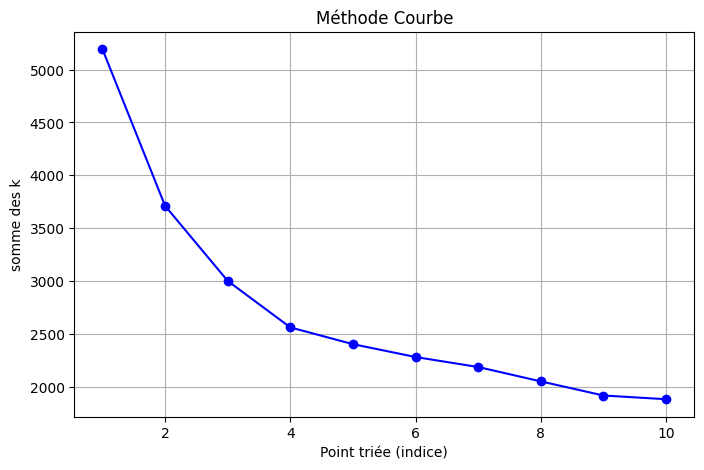

In [38]:
inertia = []

K_range = range(1,11)

for k in K_range:
    kmeans= KMeans(n_clusters=k, random_state=SEED)
    pred_kmeans = kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)
    pass

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o', color='b')
plt.title("Méthode Courbe")
plt.xlabel("Point triée (indice)")
plt.ylabel("somme des k")
plt.grid()

In [39]:
#Calcul du DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=20)

pred_db = dbscan.fit_predict(X_train)

print("CH: ", calinski_harabasz_score(X_train, pred_db))
print("Silhouette: ", silhouette_score(X_train, pred_db))
print("Davies-Bouldin: ", davies_bouldin_score(X_train, pred_db))

CH:  33.89794209417429
Silhouette:  0.35546033390778303
Davies-Bouldin:  0.834517103420129


In [40]:
ward=AgglomerativeClustering(n_clusters=k, linkage='ward')
labels_ward = ward.fit_predict(X_train)

print("Ward:")
print("CH: ", calinski_harabasz_score(X_train, labels_ward))
print("Silhouette: ", silhouette_score(X_train, labels_ward))
print("Davies-Bouldin: ", davies_bouldin_score(X_train, labels_ward))

Ward:
CH:  125.40678372747752
Silhouette:  0.12299163832987858
Davies-Bouldin:  1.7676311310619794


**5. Méthode d'ensembles** 

In [41]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier

RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)

pred_rf = RFC.predict(X_test)

print("accuracy_score: ", accuracy_score(y_test, pred_rf))
print("précision de score: ", precision_score(y_test, pred_rf))
print("rappel: ", recall_score(y_test, pred_rf))

accuracy_score:  0.704
précision de score:  0.6119402985074627
rappel:  0.4606741573033708


In [42]:
BO = GradientBoostingClassifier()
BO.fit(X_train, y_train)
pred_bo = BO.predict(X_test)


print("accuracy_score: ", accuracy_score(y_test, pred_bo))
print("précision de score: ", precision_score(y_test, pred_bo))
print("rappel: ", recall_score(y_test, pred_bo))

accuracy_score:  0.7
précision de score:  0.6
rappel:  0.47191011235955055
